<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/TRANSFERLEARNING_CROSSTEST_WESAD_CNN_45SEC_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
from scipy.stats import mannwhitneyu
from scipy.signal import welch
import ipywidgets as widgets
from IPython.display import display
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.signal import resample

In [ ]:
zip_path = "/content/drive/My Drive/WESAD/WESAD.zip"
extract_dir = "/content/WESAD_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Estrazione completata.")

Estrazione completata.


In [ ]:
pkl_files = []
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".pkl"):
            pkl_files.append(os.path.join(root, file))

print(f"Trovati {len(pkl_files)} file .pkl")

Trovati 15 file .pkl


In [ ]:
pkl_files

['/content/WESAD_data/WESAD/S4/S4.pkl',
 '/content/WESAD_data/WESAD/S14/S14.pkl',
 '/content/WESAD_data/WESAD/S9/S9.pkl',
 '/content/WESAD_data/WESAD/S3/S3.pkl',
 '/content/WESAD_data/WESAD/S16/S16.pkl',
 '/content/WESAD_data/WESAD/S8/S8.pkl',
 '/content/WESAD_data/WESAD/S6/S6.pkl',
 '/content/WESAD_data/WESAD/S11/S11.pkl',
 '/content/WESAD_data/WESAD/S13/S13.pkl',
 '/content/WESAD_data/WESAD/S15/S15.pkl',
 '/content/WESAD_data/WESAD/S5/S5.pkl',
 '/content/WESAD_data/WESAD/S17/S17.pkl',
 '/content/WESAD_data/WESAD/S2/S2.pkl',
 '/content/WESAD_data/WESAD/S7/S7.pkl',
 '/content/WESAD_data/WESAD/S10/S10.pkl']

In [ ]:
def load_all_subjects_wrist_dataframe(subject_ids, target_freq=64):
    all_data = []

    # Frequenze originali dei segnali wrist
    freq_map = {
        'ACC': 32,
        'BVP': 64,
        'EDA': 4,
        'TEMP': 4
    }
    original_label_freq = 700  # frequenza delle label

    for subject_id in subject_ids:
        file_path = f"/content/WESAD_data/WESAD/{subject_id}/{subject_id}.pkl"

        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')

        wrist = data['signal']['wrist']
        label = data['label']

        # Resample segnali
        acc = wrist['ACC']
        bvp = wrist['BVP']
        eda = wrist['EDA']
        temp = wrist['TEMP']

        acc_resampled = resample(acc, int(len(acc) * target_freq / freq_map['ACC']))
        bvp_resampled = resample(bvp, int(len(bvp) * target_freq / freq_map['BVP'])).squeeze()
        eda_resampled = resample(eda, int(len(eda) * target_freq / freq_map['EDA'])).squeeze()
        temp_resampled = resample(temp, int(len(temp) * target_freq / freq_map['TEMP'])).squeeze()

        # Downsample delle label da 700 Hz a 64 Hz
        target_len = min(len(bvp_resampled), len(eda_resampled), len(temp_resampled), acc_resampled.shape[0])
        label_resampled = resample(label, target_len).round().astype(int)

        # Creazione del DataFrame
        df = pd.DataFrame({
            'acc1': acc_resampled[:target_len, 0],
            'acc2': acc_resampled[:target_len, 1],
            'acc3': acc_resampled[:target_len, 2],
            'bvp': bvp_resampled[:target_len],
            'eda': eda_resampled[:target_len],
            'temp': temp_resampled[:target_len],
            'label': label_resampled[:target_len],
            'subject': [subject_id] * target_len
        })

        # Filtra solo label 1 (baseline) e 2 (stress)
        df = df[df['label'].isin([1, 2])].reset_index(drop=True)

        all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

In [ ]:
subject_ids = ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16", "S17"]

df = load_all_subjects_wrist_dataframe(subject_ids)

In [ ]:
print("Shape of df:", df.shape)
df.head()

Shape of df: (1765022, 8)


,acc1,acc2,acc3,bvp,eda,temp,label,subject
0,39.632707,27.934275,29.026543,-109.34,1.637743,35.809888,1,S2
1,31.000000,27.000000,28.000000,-102.80,1.635583,35.809859,1,S2
2,27.763127,26.982961,25.535968,-96.55,1.633773,35.809835,1,S2
3,29.000000,27.000000,27.000000,-90.06,1.632363,35.809819,1,S2
4,28.729609,26.571029,33.415067,-83.19,1.631390,35.809809,1,S2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765022 entries, 0 to 1765021
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   acc1     float64
 1   acc2     float64
 2   acc3     float64
 3   bvp      float64
 4   eda      float64
 5   temp     float64
 6   label    int64  
 7   subject  object 
dtypes: float64(6), int64(1), object(1)
memory usage: 107.7+ MB


In [ ]:
df.describe()

,acc1,acc2,acc3,bvp,eda,temp,label
count,1.765022e+06,1.765022e+06,1.765022e+06,1.765022e+06,1.765022e+06,1.765022e+06,1.765022e+06
mean,1.535957e+01,-6.201214e+00,8.996315e+00,1.357649e-02,2.083079e+00,3.309247e+01,1.361389e+00
std,4.294329e+01,2.986499e+01,3.132591e+01,6.748601e+01,2.789003e+00,1.447107e+00,4.804032e-01
min,-1.424491e+02,-1.404826e+02,-1.483539e+02,-1.617860e+03,7.319605e-02,2.932185e+01,1.000000e+00
25%,-2.997185e+01,-2.700567e+01,-8.000000e+00,-1.721000e+01,3.031738e-01,3.247004e+01,1.000000e+00
50%,3.385162e+01,-8.000000e+00,1.200000e+01,2.300000e+00,9.864967e-01,3.323547e+01,1.000000e+00
75%,5.300000e+01,1.100000e+01,3.300000e+01,1.864000e+01,2.891560e+00,3.399992e+01,2.000000e+00
max,1.763469e+02,1.363099e+02,1.595612e+02,1.789000e+03,1.594567e+01,3.597752e+01,2.000000e+00


In [ ]:
df['acc_mag'] = np.sqrt(df['acc1']**2+df['acc2']**2+df['acc3']**2)
df = df.drop(columns = ['acc1', 'acc2', 'acc3'], axis = 1)

In [ ]:
df.head()

,bvp,eda,temp,label,subject,acc_mag
0,-109.34,1.637743,35.809888,1,S2,56.512082
1,-102.80,1.635583,35.809859,1,S2,49.739320
2,-96.55,1.633773,35.809835,1,S2,46.378412
3,-90.06,1.632363,35.809819,1,S2,47.947888
4,-83.19,1.631390,35.809809,1,S2,51.458495


In [ ]:
df['label'] = df['label'].map({1: 0, 2: 1}).astype(int)

In [ ]:
freq_assolute = df["label"].value_counts()
freq_relative = df["label"].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Frequenza Assoluta': freq_assolute,
    'Frequenza Relativa (%)': freq_relative.round(2)*100
})

frequency_table

,Frequenza Assoluta,Frequenza Relativa (%)
label,,
0,1127162,64.0
1,637860,36.0


In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 17.8 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk

In [ ]:
ppg_raw = df["bvp"].values

fs = 64

ppg_signals, ppg_info = nk.ppg_process(ppg_raw, sampling_rate=fs)

ppg_clean = ppg_signals["PPG_Clean"]

df['bvp'] = ppg_clean

In [ ]:
eda_raw = df["eda"].values

fs = 64

eda_signals, eda_info = nk.eda_process(eda_raw, sampling_rate=fs)

eda_clean = eda_signals["EDA_Clean"]

df['eda'] = eda_clean

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def acc_denoise(acc_signal, fs):

    b_high, a_high = butter_highpass(0.5, fs)
    acc_signal = filtfilt(b_high, a_high, acc_signal)

    b_low, a_low = butter_lowpass(20.0, fs)
    acc_signal = filtfilt(b_low, a_low, acc_signal)

    return acc_signal

In [ ]:
fs = 64
df['acc_mag'] = acc_denoise(df['acc_mag'].values, fs)

In [ ]:
def temp_denoise(temp_signal, fs):
  b_low, a_low = butter_lowpass(0.5, fs)
  temp_signal = filtfilt(b_low, a_low, temp_signal)
  return temp_signal

In [ ]:
fs = 64
df['temp'] = temp_denoise(df['temp'].values, fs)

In [ ]:
df['subject'].value_counts()

,count
subject,
S10,121927
S17,121865
S15,119110
S11,119048
S14,118721
S16,118596
S13,118025
S5,117959
S8,117704


In [ ]:
fs = 64
win_sec = 45
overlap = 0.75
win_size = fs * win_sec
step_size = win_size // 2

In [ ]:
def create_windowed_array_per_signal(df, signal_col, fs=64, win_sec=45, overlap=0.75, threshold=0.7):
    win_size = int(fs * win_sec)
    step_size = int(win_size * (1 - overlap))

    X = []
    y = []
    groups = []

    for subject_id in df['subject'].unique():
        df_subj = df[df['subject'] == subject_id].reset_index(drop=True)
        signal = df_subj[signal_col].values.astype(np.float32)
        labels = df_subj['label'].values.astype(int)

        for start in range(0, len(signal) - win_size + 1, step_size):
            end = start + win_size
            window = signal[start:end]
            window_labels = labels[start:end]

            # Assegna label se almeno il 70% delle etichette nella finestra è uguale
            counts = np.bincount(window_labels, minlength=2)
            dominant_label = np.argmax(counts)
            if counts[dominant_label] / win_size >= threshold:
                X.append(window)
                y.append(dominant_label)
                groups.append(subject_id)

    X = np.array(X)[..., np.newaxis]  # aggiungi dimensione canale
    y = np.array(y).astype(int)
    groups = np.array(groups)

    return X, y, groups

In [ ]:
 segnali = ['bvp', 'eda', 'acc_mag', 'temp']

In [ ]:
X_dict = {}
for segnale in segnali:
    print(f"Processing {segnale}...")
    X, y_raw, groups = create_windowed_array_per_signal(
        df, signal_col=segnale, fs=fs, win_sec=win_sec, overlap=overlap, threshold=0.7
    )

    if segnale == segnali[0]:
        y = y_raw  # le label sono già 0/1, non serve sottrarre 1
        group_labels = groups

    X_dict[segnale] = X

Processing bvp...
Processing eda...
Processing acc_mag...
Processing temp...


In [ ]:
for segnale in segnali:
  print(f"Tipo: {type(X_dict[segnale])} Dimensione {segnale}: {X_dict[segnale].shape}")

Tipo: <class 'numpy.ndarray'> Dimensione bvp: (2379, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione eda: (2379, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione acc_mag: (2379, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione temp: (2379, 2880, 1)


In [ ]:
print(f"Tipo: {type(y)} Dimensione y: {y.shape}")

Tipo: <class 'numpy.ndarray'> Dimensione y: (2379,)


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1534,  845]))

In [ ]:
for seg in segnali:
    print(f"{seg}: {X_dict[seg].dtype}")

bvp: float32
eda: float32
acc_mag: float32
temp: float32


In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

CAMPANELLA --> WESAD

CROSS TEST CAMPANELLA CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9159
Soggetto migliore: subject_22

CROSS TEST: CAMPANELLA MODEL → WESAD DATASET
Inizio valutazione cross-test...
  Fold  1 - S10: F1=0.545 Acc=0.758
  Fold  2 - S11: F1=0.733 Acc=0.801
  Fold  3 - S13: F1=0.704 Acc=0.704
  Fold  4 - S14: F1=0.646 Acc=0.781
  Fold  5 - S15: F1=0.443 Acc=0.544
  Fold  6 - S16: F1=0.376 Acc=0.544
  Fold  7 - S17: F1=0.698 Acc=0.806
  Fold  8 - S2 : F1=0.247 Acc=0.596
  Fold  9 - S3 : F1=0.639 Acc=0.771
  Fold 10 - S4 : F1=0.595 Acc=0.781
  Fold 11 - S5 : F1=0.169 Acc=0.627
  Fold 12 - S6 : F1=0.593 Acc=0.766
  Fold 13 - S7 : F1=0.628 Acc=0.796
  Fold 14 - S8 : F1=0.760 Acc=0.849
  Fold 15 - S9 : F1=0.277 Acc=0.703

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
    S10        165    0.7576     0.9231  0.3871    0.5455
    S11        161    0.8012     0.

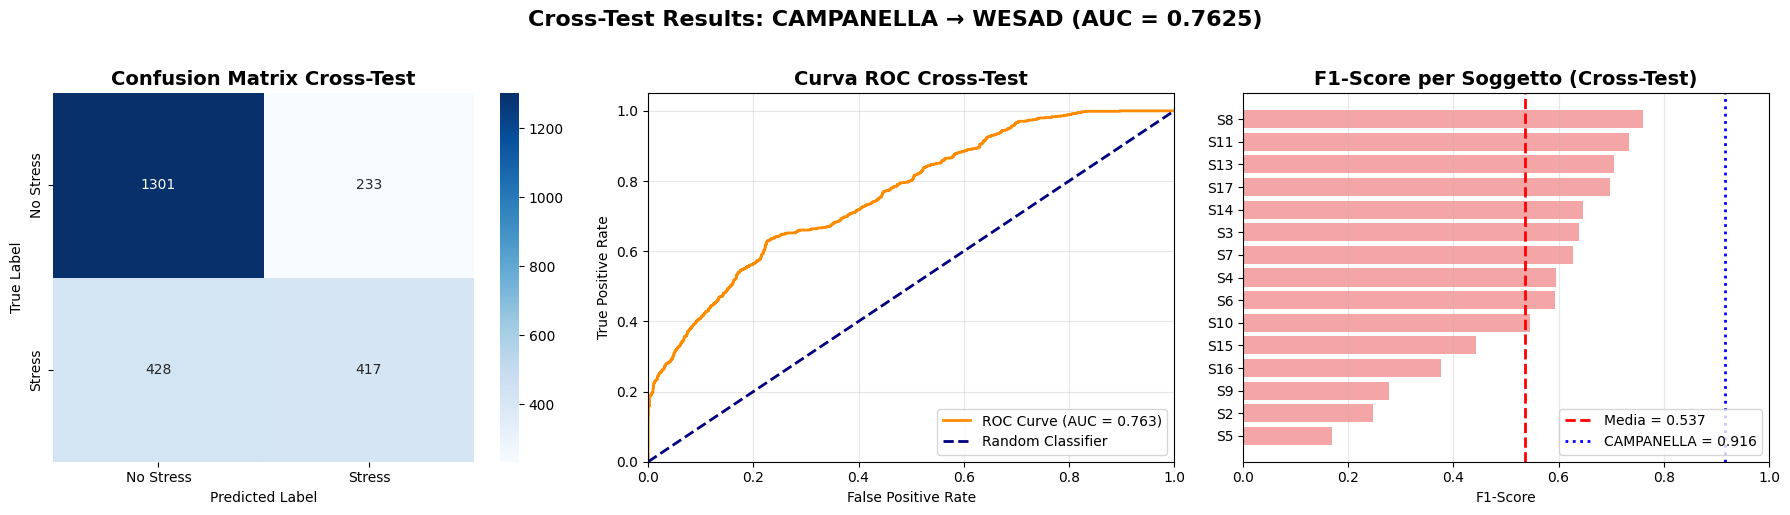


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/campanella_to_wesad_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/campanella_to_wesad_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: CAMPANELLA MODEL SU WESAD CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO CAMPANELLA
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello CAMPANELLA
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/CAMPANELLA"
campanella_model, campanella_scalers, campanella_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: CAMPANELLA MODEL → WESAD DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (WESAD)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler CAMPANELLA
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler CAMPANELLA
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = campanella_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello CAMPANELLA
    try:
        y_pred_proba = campanella_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello CAMPANELLA
        threshold = campanella_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale CAMPANELLA:")
    print(f"F1 CAMPANELLA:     {campanella_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - campanella_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance CAMPANELLA originale
        axes[2].axvline(x=campanella_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'CAMPANELLA = {campanella_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: CAMPANELLA → WESAD (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "campanella_to_wesad_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'CAMPANELLA',
        'target_dataset': 'WESAD',
        'source_f1': float(campanella_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(campanella_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "campanella_to_wesad_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING CAMPANELLA CNN

✓ Modello CAMPANELLA.keras caricato
✓ Scalers CAMPANELLA caricati
=== CAMPANELLA MODEL INFO ===
F1-Score: 0.9158878504672897
Best Subject: subject_22

TRANSFER LEARNING: CAMPANELLA → WESAD
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - S10: F1=0.672 (7ep)
  Fold  2 - S11: F1=0.754 (8ep)
  Fold  3 - S13: 

F1=0.991 (8ep)
  Fold  4 - S14: 

F1=0.697 (8ep)
  Fold  5 - S15: F1=0.635 (8ep)
  Fold  6 - S16: F1=0.583 (8ep)
  Fold  7 - S17: F1=0.795 (8ep)
  Fold  8 - S2 : F1=0.680 (8ep)
  Fold  9 - S3 : F1=0.763 (8ep)
  Fold 10 - S4 : F1=0.914 (6ep)
  Fold 11 - S5 : F1=0.846 (8ep)
  Fold 12 - S6 : F1=0.981 (8ep)
  Fold 13 - S7 : F1=0.991 (8ep)
  Fold 14 - S8 : F1=0.824 (8ep)
  Fold 15 - S9 : F1=0.657 (7ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/15
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  predicted_classes
    S10        165    0.7455     0.6515  0.6935    0.6719                  2
    S11        161    0.8012     0.6806  0.8448    0.7538                  2
    S13        159    0.9937     1.0000  0.9821    0.9910                  2
    S14        160    0.8313     0.9688  0.5439    0.6966                  2
    S15        160    0.8063     1.0000  0.4655    0.6353      

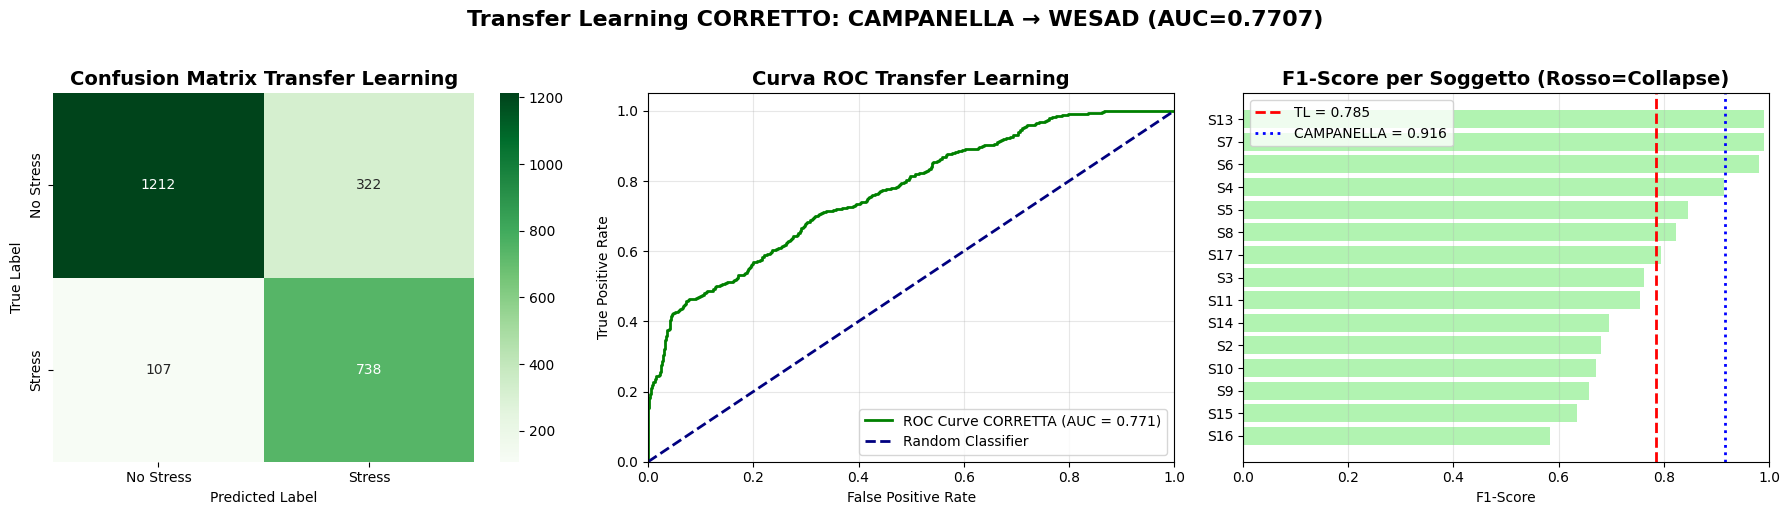


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/WESAD/CAMPANELLA_TO_WESAD_RESULTS_FIXED/campanella_to_wesad_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/WESAD/CAMPANELLA_TO_WESAD_RESULTS_FIXED/campanella_to_wesad_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: CAMPANELLA → WESAD CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO CAMPANELLA
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV CAMPANELLA se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV CAMPANELLA: {e}")
    return None

def load_source_model(model_dir, dataset_name="CAMPANELLA"):
    """Carica modello sorgente CAMPANELLA con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello CAMPANELLA
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON CAMPANELLA corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello CAMPANELLA!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers CAMPANELLA
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente CAMPANELLA
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/CAMPANELLA"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "CAMPANELLA")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: CAMPANELLA → WESAD")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (WESAD)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per CAMPANELLA
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/WESAD/CAMPANELLA_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER CAMPANELLA (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER CAMPANELLA ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler CAMPANELLA
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"CAMPANELLA originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'CAMPANELLA = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: CAMPANELLA → WESAD (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/WESAD/CAMPANELLA_TO_WESAD_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "campanella_to_wesad_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'CAMPANELLA',
        'target_dataset': 'WESAD',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "campanella_to_wesad_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")

VERBIO --> WESAD

CROSS TEST VERBIO CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9600
Soggetto migliore: P005

CROSS TEST: VERBIO MODEL → WESAD DATASET
Inizio valutazione cross-test...
  Fold  1 - S10: F1=0.452 Acc=0.721
  Fold  2 - S11: F1=0.455 Acc=0.584
  Fold  3 - S13: F1=0.000 Acc=0.623
  Fold  4 - S14: F1=0.627 Acc=0.806
  Fold  5 - S15: F1=0.991 Acc=0.994
  Fold  6 - S16: F1=0.500 Acc=0.762
  Fold  7 - S17: F1=0.546 Acc=0.376
  Fold  8 - S2 : F1=0.825 Acc=0.854
  Fold  9 - S3 : F1=0.241 Acc=0.588
  Fold 10 - S4 : F1=0.633 Acc=0.813
  Fold 11 - S5 : F1=0.497 Acc=0.475
  Fold 12 - S6 : F1=0.000 Acc=0.551
  Fold 13 - S7 : F1=0.036 Acc=0.662
  Fold 14 - S8 : F1=0.739 Acc=0.818
  Fold 15 - S9 : F1=0.965 Acc=0.975

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
    S10        165    0.7212     0.8636  0.3065    0.4524
    S11        161    0.5839     0.4308  0.48

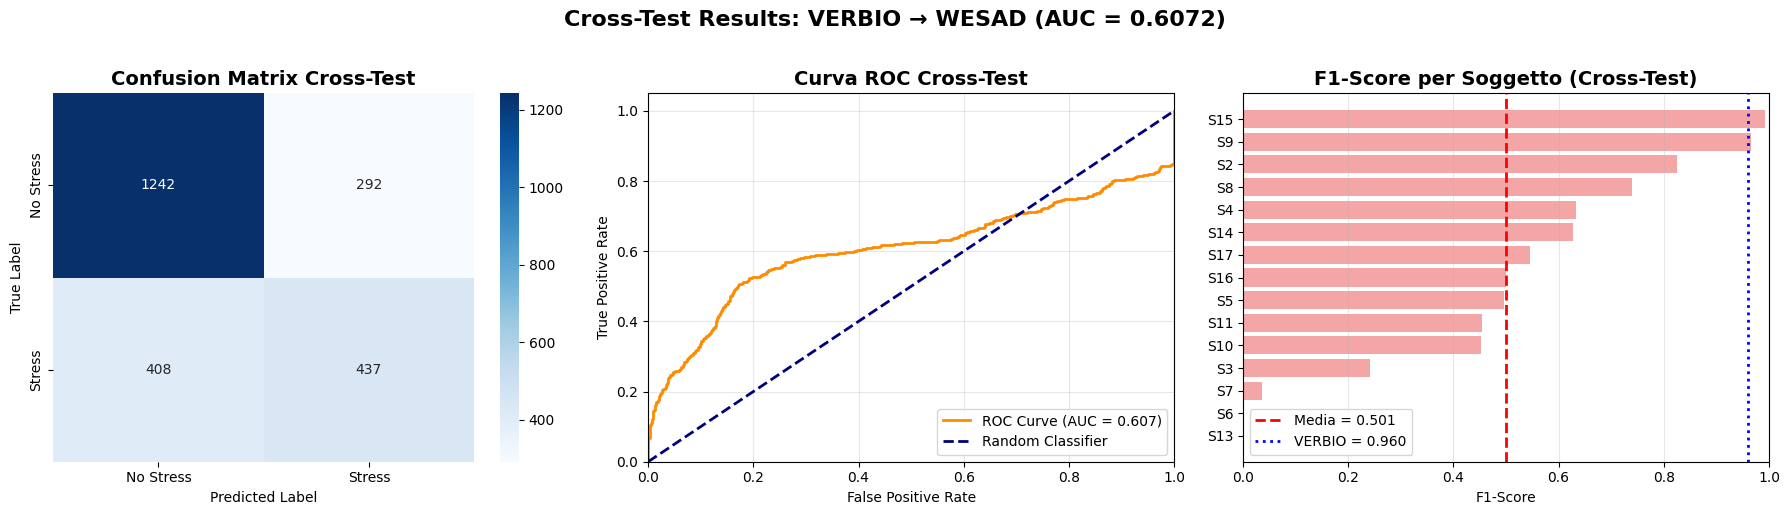


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/verbio_to_wesad_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/verbio_to_wesad_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: VERBIO MODEL SU WESAD CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO VERBIO
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello VERBIO
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO"
verbio_model, verbio_scalers, verbio_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: VERBIO MODEL → WESAD DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (WESAD)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler VERBIO
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler VERBIO
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = verbio_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello VERBIO
    try:
        y_pred_proba = verbio_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello VERBIO
        threshold = verbio_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale VERBIO:")
    print(f"F1 VERBIO:     {verbio_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - verbio_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance VERBIO originale
        axes[2].axvline(x=verbio_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'VERBIO = {verbio_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: VERBIO → WESAD (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "verbio_to_wesad_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'WESAD',
        'source_f1': float(verbio_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(verbio_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "verbio_to_wesad_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING VERBIO CNN

✓ Modello VERBIO.keras caricato
✓ Scalers VERBIO caricati
=== VERBIO MODEL INFO ===
F1-Score: 0.96
Best Subject: P005

TRANSFER LEARNING: VERBIO → WESAD
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - S10: F1=0.992 (8ep)
  Fold  2 - S11: F1=0.605 (5ep)
  Fold  3 - S13: F1=0.500 (6ep)
  Fold  4 - S14: F1=0.832 (7ep)
  Fold  5 - S15: F1=0.991 (8ep)
  Fold  6 - S16: F1=0.991 (8ep)
  Fold  7 - S17: F1=0.408 (8ep)
  Fold  8 - S2 : F1=0.803 (8ep)
  Fold  9 - S3 : F1=0.650 (8ep)
  Fold 10 - S4 : F1=0.991 (8ep)
  Fold 11 - S5 : F1=0.930 (8ep)
  Fold 12 - S6 : F1=0.981 (8ep)
  Fold 13 - S7 : F1=0.595 (5ep)
  Fold 14 - S8 : F1=0.785 (8ep)
  Fold 15 - S9 : F1=0.991 (8ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/15
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  predicted_classes
    S10        165    0.9939     1.0000  0.9839   

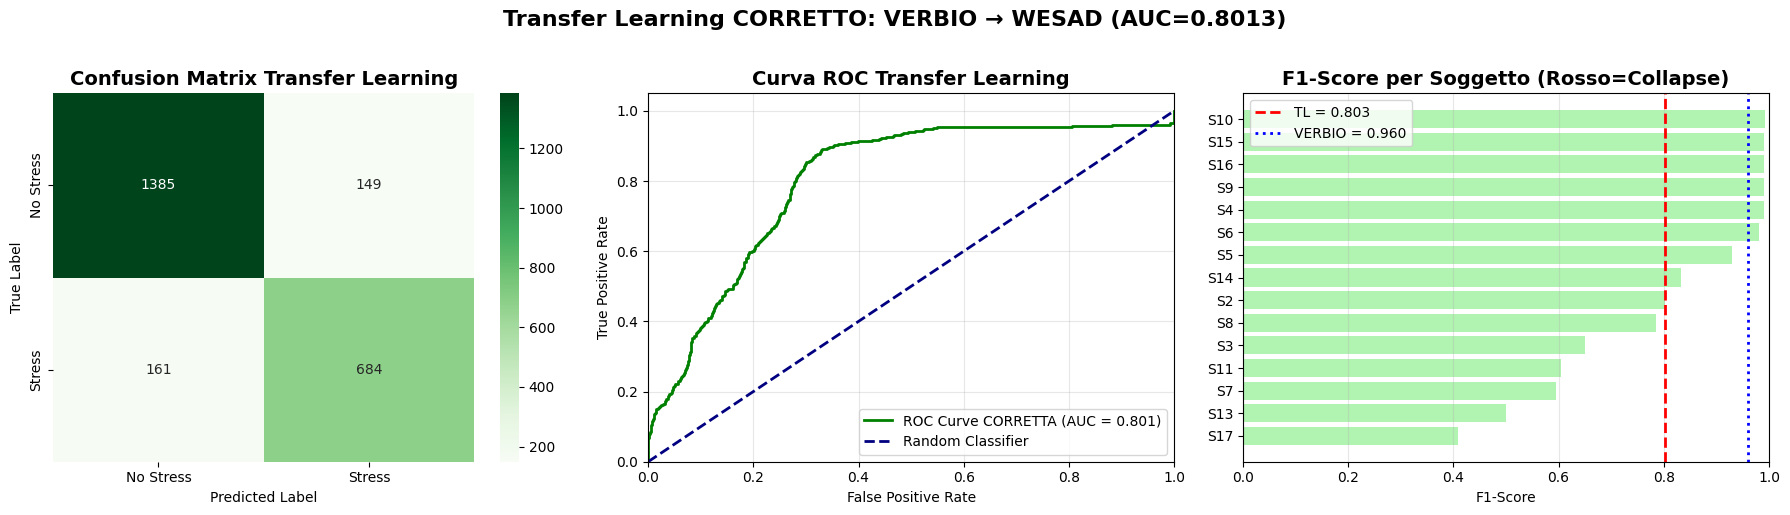


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/WESAD/VERBIO_TO_WESAD_RESULTS_FIXED/verbio_to_wesad_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/WESAD/VERBIO_TO_WESAD_RESULTS_FIXED/verbio_to_wesad_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: VERBIO → WESAD CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO VERBIO
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV VERBIO se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV VERBIO: {e}")
    return None

def load_source_model(model_dir, dataset_name="VERBIO"):
    """Carica modello sorgente VERBIO con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello VERBIO
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON VERBIO corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello VERBIO!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers VERBIO
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente VERBIO
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "VERBIO")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: VERBIO → WESAD")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (WESAD)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per WESAD
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/WESAD/VERBIO_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER VERBIO (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER VERBIO ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler VERBIO
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"VERBIO originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'VERBIO = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: VERBIO → WESAD (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/WESAD/VERBIO_TO_WESAD_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "verbio_to_wesad_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'WESAD',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "verbio_to_wesad_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")

AFFECTIVE ROAD --> WESAD

CROSS TEST AFFECTIVE ROAD CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.8360
Soggetto migliore: Drv3

CROSS TEST: AFFECTIVE ROAD MODEL → WESAD DATASET
Inizio valutazione cross-test...
  Fold  1 - S10: F1=0.522 Acc=0.733
  Fold  2 - S11: F1=0.654 Acc=0.770
  Fold  3 - S13: F1=0.630 Acc=0.704
  Fold  4 - S14: F1=0.680 Acc=0.806
  Fold  5 - S15: F1=0.583 Acc=0.750
  Fold  6 - S16: F1=0.079 Acc=0.562
  Fold  7 - S17: F1=0.690 Acc=0.788
  Fold  8 - S2 : F1=0.178 Acc=0.510
  Fold  9 - S3 : F1=0.581 Acc=0.765
  Fold 10 - S4 : F1=0.462 Acc=0.729
  Fold 11 - S5 : F1=0.000 Acc=0.608
  Fold 12 - S6 : F1=0.316 Acc=0.671
  Fold 13 - S7 : F1=0.651 Acc=0.815
  Fold 14 - S8 : F1=0.638 Acc=0.786
  Fold 15 - S9 : F1=0.219 Acc=0.684

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
    S10        165    0.7333     0.8000  0.3871    0.5217
    S11        161    0.7702     0.71

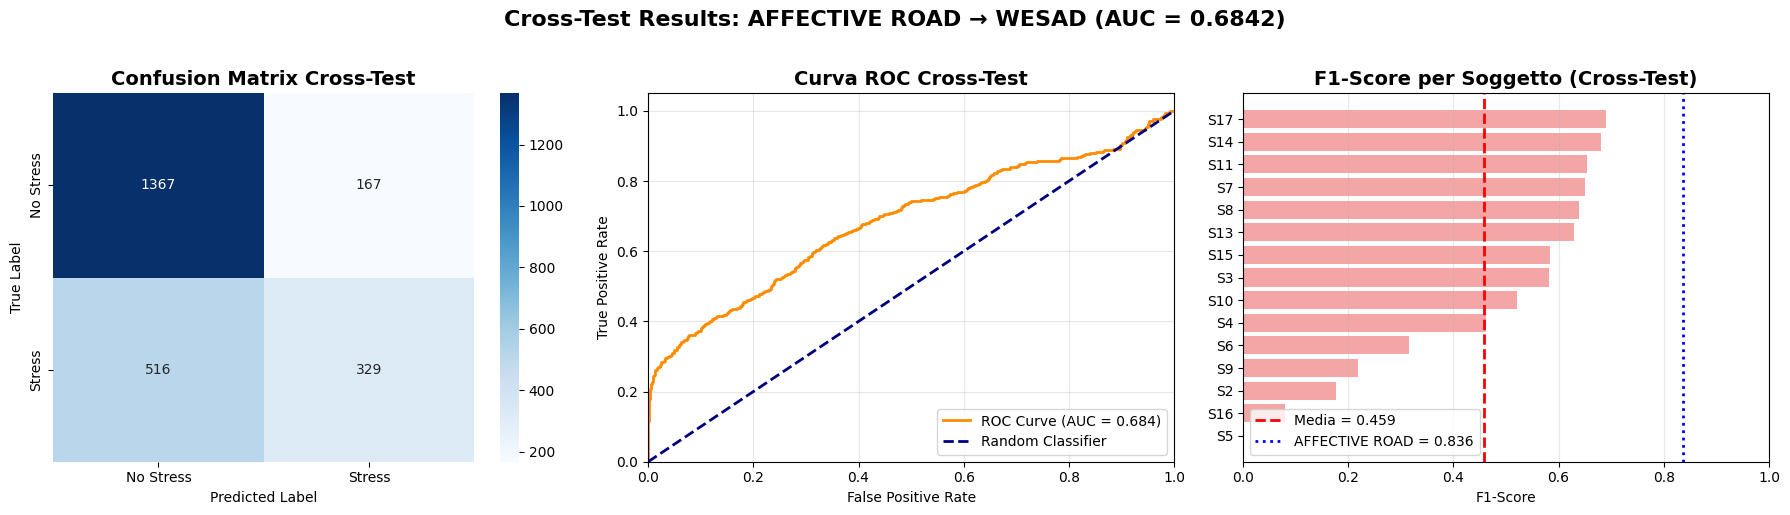


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/affectiveroad_to_wesad_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/affectiveroad_to_wesad_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: AFFECTIVE ROAD MODEL SU WESAD CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO AFFECTIVE ROAD
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello AFFECTIVE ROAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/AFFECTIVE ROAD"
affectiveroad_model, affectiveroad_scalers, affectiveroad_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: AFFECTIVE ROAD MODEL → WESAD DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (WESAD)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler AFFECTIVE ROAD
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler AFFECTIVE ROAD
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = affectiveroad_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello AFFECTIVE ROAD
    try:
        y_pred_proba = affectiveroad_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello AFFECTIVE ROAD
        threshold = affectiveroad_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale AFFECTIVE ROAD:")
    print(f"F1 AFFECTIVE ROAD:     {affectiveroad_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - affectiveroad_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance AFFECTIVE ROAD originale
        axes[2].axvline(x=affectiveroad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'AFFECTIVE ROAD = {affectiveroad_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: AFFECTIVE ROAD → WESAD (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "affectiveroad_to_wesad_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'AFFECTIVE ROAD',
        'target_dataset': 'WESAD',
        'source_f1': float(affectiveroad_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(affectiveroad_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "affectiveroad_to_wesad_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING AFFECTIVE ROAD CNN

✓ Modello AFFECTIVE ROAD.keras caricato
✓ Scalers AFFECTIVE ROAD caricati
=== AFFECTIVE ROAD MODEL INFO ===
F1-Score: 0.8359788359788359
Best Subject: Drv3

TRANSFER LEARNING: AFFECTIVE ROAD → WESAD
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - S10: F1=0.505 (8ep)
  Fold  2 - S11: F1=0.644 (8ep)
  Fold  3 - S13: F1=0.780 (8ep)
  Fold  4 - S14: F1=0.711 (8ep)
  Fold  5 - S15: F1=0.628 (5ep)
  Fold  6 - S16: F1=0.593 (5ep)
  Fold  7 - S17: F1=0.704 (8ep)
  Fold  8 - S2 : F1=0.637 (8ep)
  Fold  9 - S3 : F1=0.561 (8ep)
  Fold 10 - S4 : F1=0.870 (8ep)
  Fold 11 - S5 : F1=0.706 (8ep)
  Fold 12 - S6 : F1=0.885 (8ep)
  Fold 13 - S7 : F1=0.946 (8ep)
  Fold 14 - S8 : F1=0.667 (8ep)
  Fold 15 - S9 : F1=0.333 (8ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/15
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  predicted_classes
    

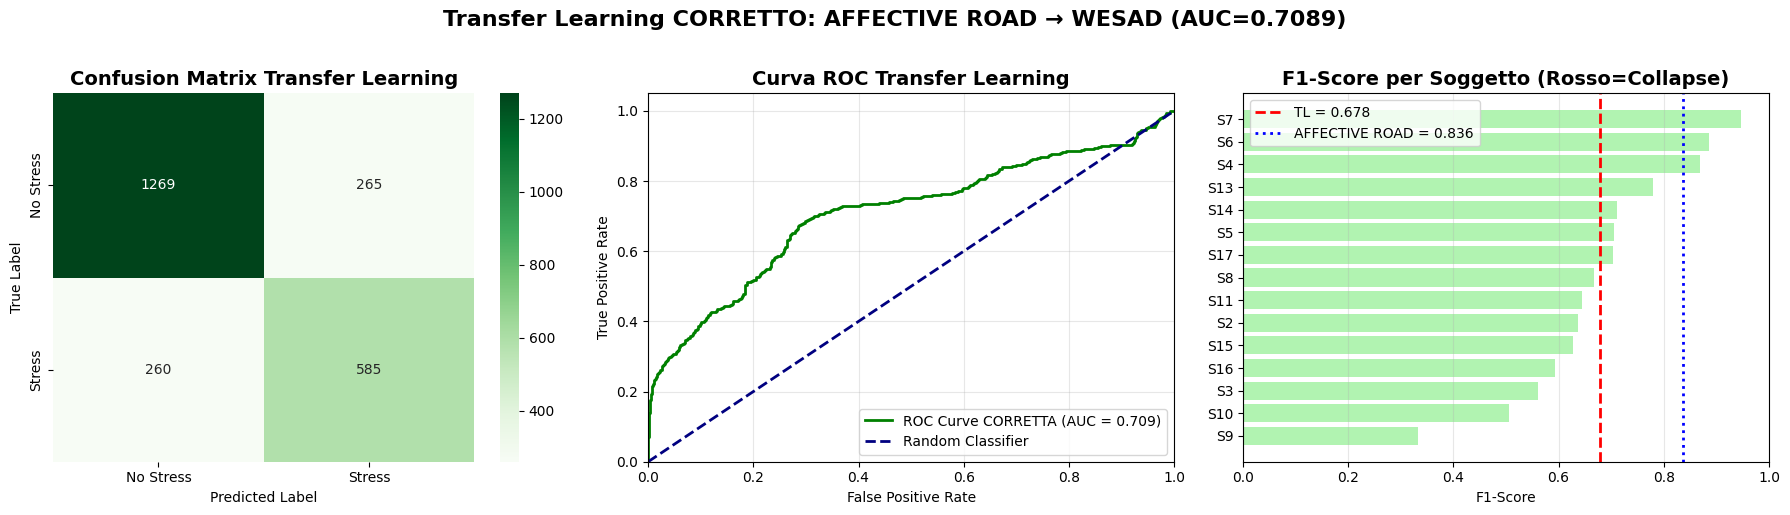


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/WESAD/AFFECTIVEROAD_TO_WESAD_RESULTS_FIXED/affectiveroad_to_wesad_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/WESAD/AFFECTIVEROAD_TO_WESAD_RESULTS_FIXED/affectiveroad_to_wesad_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: AFFECTIVE ROAD → WESAD CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO AFFECTIVE ROAD
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV AFFECTIVE ROAD se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/AffectiveRoad Dataset/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/AffectiveRoad Dataset/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV AFFECTIVE ROAD: {e}")
    return None

def load_source_model(model_dir, dataset_name="AFFECTIVE ROAD"):
    """Carica modello sorgente AFFECTIVE ROAD con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello AFFECTIVE ROAD
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON AFFECTIVE ROAD corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello AFFECTIVE ROAD!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers AFFECTIVE ROAD
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente AFFECTIVE ROAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/AFFECTIVE ROAD"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "AFFECTIVE ROAD")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: AFFECTIVE ROAD → WESAD")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (WESAD)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per WESAD
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/WESAD/AFFECTIVEROAD_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER AFFECTIVE ROAD (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER AFFECTIVE ROAD ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler AFFECTIVE ROAD
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"AFFECTIVE ROAD originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'AFFECTIVE ROAD = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: AFFECTIVE ROAD → WESAD (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/WESAD/AFFECTIVEROAD_TO_WESAD_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "affectiveroad_to_wesad_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'WESAD',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "affectiveroad_to_wesad_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")